In [99]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io.wavfile as wav
import os

from collections import namedtuple
from scipy.fft import rfft, rfftfreq
from scipy.signal import find_peaks


# decompose a signal into non overlapping frames
def non_overlapping_frames(signal, fs, frame_duration):
    frame_len = round(frame_duration * fs)
    total_frames = len(signal) // frame_len

    frames = signal[: total_frames * frame_len]
    frames = frames.reshape(frame_len, total_frames, order="F")

    return frames


# plot a signal in continuous time
def plot_continuous(signal, fs, title, ylabel=None):
    t = np.arange(len(signal)) / fs

    plt.plot(t, signal)
    plt.xlabel("Time (s)")
    plt.title(title)

    if ylabel:
        plt.ylabel(ylabel)

    plt.show()


# plot a signal in both continuous and discrete time in the same plot
def plot_continuous_and_discrete(
    signal, fs, title, discrete_vlines=None, continuous_vlines=None
):
    signal_len = len(signal)
    t = np.arange(signal_len) / fs
    n = np.arange(signal_len)

    fig, ax = plt.subplots(2, layout="constrained")

    # plot the signal in continuous time
    ax[0].plot(t, signal)
    ax[0].set_xlabel("Time (s)")
    ax[0].set_title("Continuous")

    if continuous_vlines is not None:
        for vline in continuous_vlines:
            ax[0].axvline(vline, color="r")

    # plot the signal in discrete time
    ax[1].plot(n, signal)
    ax[1].set_xlabel("n")
    ax[1].set_title("Discrete")

    if discrete_vlines is not None:
        for vline in discrete_vlines:
            ax[1].axvline(vline, color="r")

    fig.suptitle(title)
    plt.show()


# calculate the fundamental frequency of a signal using fft
def calculate_fundamental_frequency(signal, fs):
    # calculate the fft of the signal
    spectrum = fft(signal)

    # calculate the magnitude of the spectrum
    magnitude = np.abs(spectrum)

    # find the peaks
    peaks, _ = find_peaks(magnitude)

    # calculate the frequencies of the peaks
    frequencies = np.arange(len(magnitude)) * fs / len(magnitude)

    # find the peak with the highest frequency
    max_peak = peaks[np.argmax(magnitude[peaks])]

    return frequencies[max_peak]

## Ejercicio 2.1
Representamos la señal en tiempo discreto y continuo.
También representamos la energia de la señal calculada en frames de 20ms sin solape

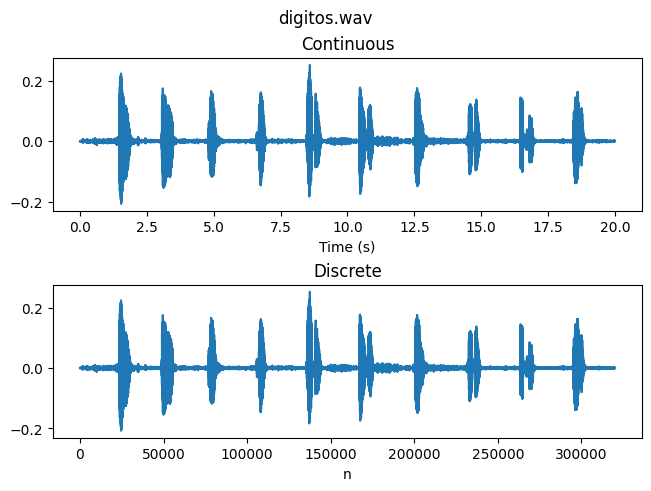

In [100]:
AUDIO_DIR = "audio/"


# Create a named tuple to represent a signal
Signal = namedtuple("Signal", ["y", "fs", "file"])

# get the signal and the sampling frequency
signal_path = os.path.join(AUDIO_DIR, "digitos.wav")
fs, y = wav.read(signal_path)

# normalize the signal
# signals are stored as 16-bit signed integers
y = y / 2**15

# create the Signal object
signal = Signal(y, fs, os.path.basename(signal_path))

# represent the signal in continuous and discrete time
plot_continuous_and_discrete(signal.y, signal.fs, signal.file)

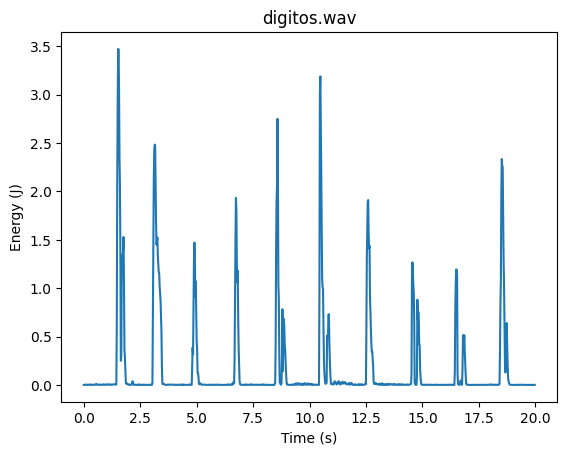

In [101]:
frame_duration = 0.02  # frame duration in seconds
fs = 1 / frame_duration  # sampling frequency

# calculate the energy of the signal in non-overlapping frames
energy_frames = non_overlapping_frames(signal.y, signal.fs, frame_duration)
signal_energy = (energy_frames**2).sum(axis=0)

# represent the energy of the signal in continuous time
plot_continuous(signal_energy, fs, signal.file, "Energy (J)")

## Ejercicio 2.2
Representamos la señal en tiempo continuo y discreto remarcando los valores escogidos del inicio y del final de cada dígito

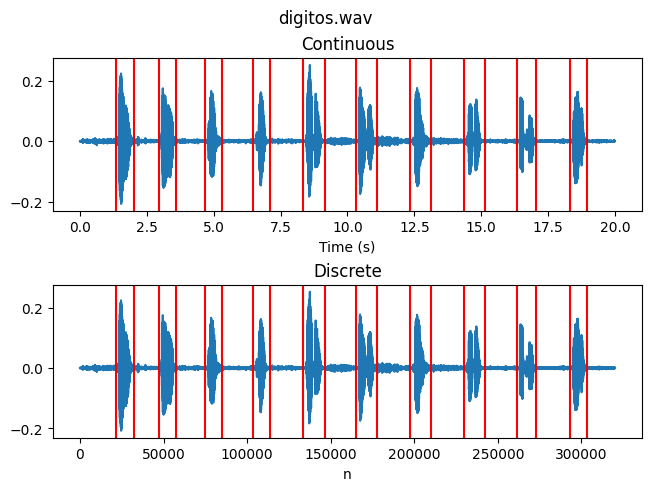

In [102]:
# values hand picked from the plot to represent the speech segments ignoring the silences between them
discrete_speech_segments = np.array(
    [
        (21500, 32500),
        (47000, 57500),
        (75000, 85000),
        (103500, 113500),
        (133500, 146500),
        (165000, 177500),
        (197500, 210000),
        (230000, 242000),
        (261500, 273000),
        (293000, 303000),
    ]
)

# convert the speech segments to continuous time
continuous_speech_segments = discrete_speech_segments / signal.fs

# represent the signal in continuous and discrete time with the speech segments highlighted
plot_continuous_and_discrete(
    signal.y,
    signal.fs,
    signal.file,
    continuous_vlines=continuous_speech_segments.flatten(),
    discrete_vlines=discrete_speech_segments.flatten(),
)

## Ejercicio 2.3
Recortamos la señal original, extrayendo cada dígito y guardándolo en un archivo .wav
Añadimos 0.5 segundos de silencia tanto al principio como al final de señal.

In [103]:
silence_offset = 0.5  # silence offset in seconds
silence_offset_samples = round(silence_offset * signal.fs)  # silence offset in samples

# extract the speech segments from the signal
digit_signals = [
    signal.y[start - silence_offset_samples : end + silence_offset_samples]
    for start, end in discrete_speech_segments
]

# dictionary with the digit names to use as file names
digits_name_dict = {
    0: "cero",
    1: "uno",
    2: "dos",
    3: "tres",
    4: "cuatro",
    5: "cinco",
    6: "seis",
    7: "siete",
    8: "ocho",
    9: "nueve",
}

# save the digit signals in the audio directory
for i, digit in enumerate(digit_signals):
    digit_path = os.path.join(AUDIO_DIR, f"{digits_name_dict[i]}.wav")
    # wav.write(digit_path, signal.fs, digit)